In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/optiver_real_vol')

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

!pip install shap
!pip install optuna



Mounted at /content/drive
Mon Feb 19 06:27:16 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0              40W / 350W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------

In [2]:
import shap
import pickle
from datetime import datetime
import os
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
import seaborn as sns

import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
from xgboost import plot_tree
from sklearn.utils import class_weight
from xgboost import plot_importance

from sklearn.model_selection import RepeatedKFold, cross_val_score, TimeSeriesSplit

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.genmod.generalized_linear_model import GLM
import scipy.stats as stats

from sklearn.cluster import KMeans
import re

import warnings
#warnings.filterwarnings("ignore")
from sklearn.metrics import confusion_matrix
#from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


from sklearn.utils import class_weight
import optuna
from optuna.trial import TrialState

from mlxtend.evaluate import bias_variance_decomp

In [3]:
## get labels of features and target

os.chdir('/content/drive/MyDrive/optiver_real_vol/Datasets/liquidity_features')


# with open('int32_feat_labels.pkl', 'rb') as fp:
#     int32_feat_labels = pickle.load(fp)
# with open('int64_feat_labels.pkl', 'rb') as fp:
#     int64_feat_labels = pickle.load(fp)

# with open('float32_feat_labels.pkl', 'rb') as fp:
#     float32_feat_labels = pickle.load(fp)
# with open('float64_feat_labels.pkl', 'rb') as fp:
#     float64_feat_labels = pickle.load(fp)

# with open('target_labels.pkl', 'rb') as fp:
#     target_labels = pickle.load(fp)



os.chdir('/content/drive/MyDrive/optiver_real_vol/Datasets/liquidity_features')
with open('train_feat_df_reordered.pkl', 'rb') as fp:
    train_feat_df_reordered = pickle.load(fp)

df1 = train_feat_df_reordered.copy()
del train_feat_df_reordered

In [4]:
#### hand picked features for training

hand_picked_cols = [
    "time_id",
    "stock_id",
    "log_liq2_ret__wap_eqi_price1_ret_vol",
    "exp_log_liq1_ret__wap_eqi_price1_ret_vol",
    "wap1_log_price_ret_per_liq2_vol",
    "wap1_log_price_ret_per_spread_sqr_vol",
    "wap1_log_price_ret_neg_log_liq_ret_sqr_vol",
    "wap1_log_price_ret_pos_log_liq_ret_sqr_vol",
    "wap1_log_price_ret_posneg_log_liq_ret_sqr_vol",
    "soft_stock_mean_tvpl2_liqf",
    "lsvol",
    "liqvol1",
    "trade_count",
    "root_book_delta_count",
    "tvpl2",
    "log_wap1_log_price_ret_vol",
    "log_first_10_min_vol_stnd",
    "log_1e3_trade_price_real_vol_stnd",
    "log1p_trade_order_count_std_stnd",
    "log1p_trade_order_count_mean_stnd",
    "log_target_vol_corr_32_clusters_stnd",
    "log_target_vol_sum_stats_16_clusters_stnd",
    "max_bid_price1",
    "max_ask_price1",
    "log_max_bid_size1_stnd",
    "log_1e3_range_bid_price1_stnd",
    "log1p_range_ask_size1_stnd",
    "log1p_sad_ask_size1_stnd",
    "log_1e2_sad_bid_price1_stnd",
    "exp_bs_as_corr1_stnd",
    "bs_ap_corr1",
    "max_price1",
    "log_max_size1_stnd",
    "log1p_range_order_count1_stnd",
    "log_1e3_sad_price1_stnd",
    "log1p_sad_size1_stnd",
    "size_order_count_corr1",
    "log_book_ewma_vol_stnd",
    "log1p_trade_ewma_vol_stnd",
    "max_bid_price2",
    "max_ask_price2",
    "log_max_bid_size2_stnd",
    "log_1e3_range_ask_price2_stnd",
    "log_range_ask_size2_stnd",
    "log_1e3_sad_bid_price2_stnd",
    "bs_bp_corr2",
    "bs_ap_corr2",
    "as_ap_corr2",
    "sum_stats_4_clusters_labels",
    "sum_stats_10_clusters_labels",
    "sum_stats_16_clusters_labels",
    "sum_stats_30_clusters_labels",
    "pear_corr_32_clusters_labels",
    "pear_corr_4_clusters_labels",
    "pear_corr_49_clusters_labels",
    "pear_corr_90_clusters_labels",
    "exp_root_trade_count_var_stnd",
    "seq_id",
    "per9_id",
    "per45_id",
    "per189_id",
    #"target",
    'target' # log target is easier to transform back than log_target_standardized
]


In [5]:
# prompt: given a dataframe, df create lists of columns that belong to different datatypes

df2 = df1[hand_picked_cols]
del df1
df2.replace(-np.inf, -1e8, inplace=True)
df2.replace(np.inf, 1e8, inplace=True)

obj_feat_labels = [col for col, dtype in df2.dtypes.items() if dtype == 'object']
int16_feat_labels = [col for col, dtype in df2.dtypes.items() if dtype == 'int16']
int32_feat_labels = [col for col, dtype in df2.dtypes.items() if dtype == 'int32']
int64_feat_labels = [col for col, dtype in df2.dtypes.items() if dtype == 'int64']
float32_feat_labels = [col for col, dtype in df2.dtypes.items() if dtype == 'float32']
float64_feat_labels = [col for col, dtype in df2.dtypes.items() if dtype == 'float64']
float64_feat_labels.remove('target') #target, log_target

df2[obj_feat_labels] = df2[obj_feat_labels].astype('category')
df2[int16_feat_labels] = df2[int16_feat_labels].astype('category')
df2[int32_feat_labels] = df2[int32_feat_labels].astype('category')
df2[int64_feat_labels] = df2[int64_feat_labels].astype('category')

cat_feat_labels = obj_feat_labels+int16_feat_labels +int32_feat_labels+ int64_feat_labels

##### Temporarily add sequence_id within each stock and the periodic information here

In [ ]:
""" ADD this code to other datasets as well!! """

# #### take reordered train_feat_df and include monotonically increasing sequence id, daily period, ordinal feature, weekly period ordinal feature and monthly period ordinal feature

# def my_seq_fill(x):
#   return np.tile(range(3830),1 )[:len(x)]

# def my_per9_fill(x):
#   return np.tile(range(9),426 )[:len(x)]

# def my_per45_fill(x):
#   return np.tile(range(45),86 )[:len(x)]

# def my_per189_fill(x):
#   return np.tile(range(189),21 )[:len(x)]

# import numpy as np
# x = pd.DataFrame({ 'stock_id': df['stock_id'].values  })

# seq_id =x.groupby('stock_id').apply(lambda x:my_seq_fill(x))
# seq_id = pd.DataFrame(seq_id).explode(0)
# seq_id

# per9_id =x.groupby('stock_id').apply(lambda x:my_per9_fill(x))
# per9_id = pd.DataFrame(per9_id).explode(0)
# per9_id

# per45_id =x.groupby('stock_id').apply(lambda x:my_per45_fill(x))
# per45_id = pd.DataFrame(per45_id).explode(0)
# per45_id

# per189_id =x.groupby('stock_id').apply(lambda x:my_per189_fill(x))
# per189_id = pd.DataFrame(per189_id).explode(0)
# per189_id

# df['seq_id'] = seq_id[0].values
# df['per9_id'] = per9_id[0].values
# df['per45_id'] = per45_id[0].values
# df['per189_id'] = per189_id[0].values
# df

# pickle.dump( df ,open('train_feat_df_reordered.pkl','wb') )

' ADD this code to other datasets as well!! '

In [ ]:
# #### remove one of redundant columns, wap1_log_price_ret_vol and log_wap1_log_price_ret_vol

# df.drop(columns=['wap1_log_price_ret_vol'], inplace=True)
# pickle.dump( df ,open('train_feat_df_reordered.pkl','wb') )

# train_feat_df.drop(columns=['wap1_log_price_ret_vol'], inplace=True)
# pickle.dump( train_feat_df ,open('train_feat_df.pkl','wb') )

In [87]:
class train_validate_n_test(object):

    def __init__(self,df) -> None:

        self.time_id_order = df.loc[:3829,'time_id'].values # select ordered unique time_ids
        self.train_time_id_ind = int(len(self.time_id_order)*0.7)
        self.n_folds = 10
        folds = TimeSeriesSplit(n_splits=self.n_folds,)# max_train_size=None, gap=10)
        self.splits = folds.split( range( self.train_time_id_ind ) ) # split 70% train time_ids into n_fold splits

        train_time_ids = self.time_id_order[:self.train_time_id_ind]
        self.train_stock_id = df[df['time_id'].isin(train_time_ids)]['stock_id']
        self.train_time_id = df[df['time_id'].isin(train_time_ids)]['time_id']

        test_time_ids = self.time_id_order[self.train_time_id_ind:]
        self.test_df = df[df['time_id'].isin(test_time_ids)]
        self.test_stock_id = self.test_df['stock_id']
        self.test_time_id = self.test_df['time_id']
        self.df = df

        # feature_importances = pd.DataFrame()
        self.feat_cols_list = cat_feat_labels+float32_feat_labels+float64_feat_labels # int32_feat_labels+int64_feat_labels+float32_feat_labels+float64_feat_labels
        # feature_importances['feature'] = self.feat_cols_list

        self.target_name = 'target' # _standardized' log target is easier to transform back than log_target_standardized

        del df

    # def onehotencode_cat_var(self,full_set):
    #     full_set = cat_feat_labels #full_set.astype({"stn_id":str,"block_id":str,"ts_of_day":str,"hr_of_day":str,"day_of_wk":str,"day_of_mn":str,"wk_of_mon":str })
    #     full_set = pd.get_dummies(full_set, prefix_sep="_",columns =cat_feat_labels,drop_first=True)
    #     #ds_df = ds_df.drop('rem_blk_outf_'+self.stn,axis=1)
    #     return full_set

    #### RMSPE cost function
    def rmspe(self,y_true, y_pred):
        return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))


    # Custom RMSPE objective function
    def rmspe_objective(self,preds, dtrain):
        labels = dtrain.get_label()
        errors = (preds - labels) / labels
        gradient = 2 * errors / (1 + errors**2)
        hessian = 2 * (1 - errors**2) / (1 + errors**2)**2
        return gradient, hessian


    def xgb_RMSPE(self,preds, train_data):
        labels = train_data.get_label()
        return 'RMSPE', round(self.rmspe(y_true = labels, y_pred = preds),5)


    def nancorr(self,a, b):
        v = np.isfinite(a)*np.isfinite(b) > 0
        return np.corrcoef(a[v], b[v])[0,1]


    def xgb_train_validate(self,params_xgb,n_rounds,esr,trial):
        rmspe_val_score = []
        models= []
        test_y_preds = np.zeros(len(self.test_df))
        best_iterations = []
        learning_train_rmspe = []
        learning_val_rmspe = []

        for fold_n, (train_index, valid_index) in enumerate(self.splits):
            print('Fold:',fold_n+1)
            # print('train_index',train_index)
            # print('valid_index',valid_index)
            train_time_ids = self.time_id_order[train_index]
            val_time_ids = self.time_id_order[valid_index]
            train_df = self.df[self.df['time_id'].isin(train_time_ids)]
            val_df = self.df[self.df['time_id'].isin(val_time_ids)]

            X_train = train_df[self.feat_cols_list]
            y_train = train_df[self.target_name] # target
            X_valid = val_df[self.feat_cols_list]
            y_val = val_df[self.target_name] # target

            v1tr = np.exp(X_train['log_wap1_log_price_ret_vol']) # double exponential to nullify the log
            v1v = np.exp(  X_valid['log_wap1_log_price_ret_vol']) # double exponential to nullify the log

            # v1tr = np.exp(np.exp(X_train['log_wap1_log_price_ret_vol'])) # double exponential to nullify the log
            # v1v = np.exp(np.exp(  X_valid['log_wap1_log_price_ret_vol'])) # double exponential to nullify the log
            #v1ts = np.exp(np.exp( self.test_df['log_wap1_log_price_ret_vol'])) # double exponential to nullify log

            w_train = y_train **-2 * v1tr**2
            w_val = y_val **-2 * v1v**2

            print('Training....')
            dtrain = xgb.DMatrix(X_train, label=y_train/v1tr,weight=w_train,enable_categorical=True)
            dvalid = xgb.DMatrix(X_valid,   label=  y_val/v1v,weight=w_val,enable_categorical=True)
            watchlist  = [(dtrain,'train_loss_fold_'+str(fold_n+1)), (dvalid, 'val_loss_fold_'+str(fold_n+1))]
            evals_result = {}
            reg = xgb.train(params=params_xgb, dtrain=dtrain, num_boost_round=n_rounds, evals=watchlist, obj=self.rmspe_objective,custom_metric=self.xgb_RMSPE,  evals_result=evals_result,maximize=False,  early_stopping_rounds=esr,verbose_eval=False)
            learning_train_rmspe.append(evals_result['train_loss_fold_'+str(fold_n+1)])
            learning_val_rmspe.append(evals_result['val_loss_fold_'+str(fold_n+1)])

            models.append(reg)
            best_iterations.append(reg.best_iteration)

            p = reg.predict(dvalid)*v1v
            val_score =  np.mean( ((p-y_val)/y_val)**2 )**0.5

            # full_score += y_val.shape[0]*score**2

            print(f'fold: {fold_n+1}, val rmspe score is {val_score}')
            print('corr(p/v1v, y_val/v1v)',self.nancorr(       p/v1v ,        y_val/v1v ))
            print('log(corr( ))',self.nancorr(np.log(p/v1v), np.log(y_val/v1v)))
            print('corr(p, y_val)',self.nancorr(p, y_val))
            print('log(corr( ))',self.nancorr(np.log(p), np.log(y_val)))

            #test_pred = reg.predict(self.test_df[self.feat_cols_list] )*v1ts ## this method is not suitable for Timeseries cross validation because initial splits are too far from test set.
            #test_y_preds += test_pred/self.n_folds

            rmspe_val_score.append(val_score)

        mean_rmspe_val_score = np.mean(rmspe_val_score)
        print(f'mean rmspe val score over {self.n_folds} splits is',mean_rmspe_val_score)
        #print(f'mean rmspe test score: ',  np.mean( ((test_y_preds-self.test_df[self.target_name])/self.test_df[self.target_name])**2 )**0.5  ) # target

        # Plot learning curves
        fig,ax = plt.subplots(2,1,figsize=(10,6))
        for fold_n in range(len(rmspe_val_score)):
            ax[0].plot(learning_train_rmspe[fold_n]['RMSPE'], label=f'Fold {fold_n+1} Train RMSPE')
            ax[0].plot(learning_val_rmspe[fold_n]['RMSPE'],linestyle='dashed', label=f'Fold {fold_n+1} Validation RMSPE')
        last_fold = len(rmspe_val_score) - 1
        ax[1].plot(learning_val_rmspe[last_fold]['RMSPE'],linestyle='dashed', label=f'Fold {last_fold+1} Validation RMSPE')
        ax[1].set_xlabel('Boosting Round')
        ax[0].set_ylabel('RMSPE')
        ax[1].set_ylabel('RMSPE')
        ax[0].legend()
        ax[1].legend()
        ax[0].grid(True)
        ax[1].grid(True)
        fig.suptitle(f'Learning Curves, Trial: {trial.number}')
        fig.show()

        del self.df, X_train, X_valid, y_train, y_val,train_df,val_df,dtrain,dvalid, v1tr, v1v
        gc.collect()
        return mean_rmspe_val_score,best_iterations[-1]


    def manual_shapley_addivity_check(self,model_base_value,all_stock_train_pred_df,all_stock_v1tr_df,all_stock_y_train_df,shap_values,stock_id,view_time_ids_start,view_time_ids_end,feature_name):

        y_train_true = all_stock_y_train_df[stock_id].values[view_time_ids_start:view_time_ids_end]
        model_pred = all_stock_train_pred_df[stock_id].values[view_time_ids_start:view_time_ids_end]
                #### ONLY for Explainer
        shap_pred = ( shap_values.base_values + shap_values.values.sum(axis=1) )* all_stock_v1tr_df[stock_id].values[view_time_ids_start:view_time_ids_end]

                #### ONLY for TreeExplainer
        #shap_pred = ( model_base_value + shap_values.sum(axis=1) )* all_stock_v1tr_df[stock_id].values[view_time_ids_start:view_time_ids_end]

        #print('shap_values.sum(axis=1)',shap_values.sum(axis=1))
        # print('shap_values.base_values',shap_values.base_values[0])
        # print('shap_values.values',shap_values.values[0].sum())
        #print('len(shap_values.values.sum(axis=1))',len(shap_values.values.sum(axis=1)))

        model_shap_rmspe = self.rmspe(model_pred, shap_pred)

        fig, ax = plt.subplots(figsize=(30,5))
        ax.plot(np.arange(0,len(y_train_true)),y_train_true,label='true rvol.',linestyle='dashed',c='g',marker='*',alpha=0.2)
        ax.plot(np.arange(0,len(model_pred)),model_pred,label='model prediction',linestyle='dashed',c='b',marker='*',alpha=0.6)
        ax.plot(np.arange(0,len(shap_pred)),shap_pred,label='summed shap values prediction',linestyle='dashed',c='r',marker='*',alpha=0.6)
        ax.set_title(f'Check additivity of shap values, RMSPE:{model_shap_rmspe} between model and shap values prediction' )
        ax.set_ylabel('rvol.')
        ax.legend()
        ax.grid(True)
        fig.show()


        del all_stock_train_pred_df,all_stock_v1tr_df,all_stock_y_train_df,shap_values
        gc.collect()
        return


    def compute_shapley_PDP_n_Scatter(self,feature_name,shap_values):
        ####### compute partial dependence plot of most important features

        ###### Partial dependence plot
        #fig,ax = plt.subplots()
        #shap.plots.partial_dependence(feature_name, model.predict, xgb.DMatrix(X_train,enable_categorical=True), model_expected_value=True, feature_expected_value=True)
        #fig.show()

        ##### scatter plot
        print(f'\n scatter plot of {feature_name} vs. shap values')
        #fig,ax = plt.subplots()
        shap.plots.scatter(shap_values[:,feature_name])
        #fig.show()

        del shap_values
        gc.collect()
        return

    def compute_shapley_beeswarm(self,X,shap_values,all_stock_v1tr_df,stock_id,view_time_ids_start,view_time_ids_end):

        #### ONLY for TreeExplainer
        # plt.figure()
        # stock_v1tr_df = all_stock_v1tr_df[stock_id].values[view_time_ids_start:view_time_ids_end]
        # shap_values = np.multiply(shap_values.T ,stock_v1tr_df).T
        # shap.summary_plot(shap_values, X)
        # plt.title(f'stock id: {stock_id}, view_time_ids_start:  {view_time_ids_start}, view_time_ids_end: {view_time_ids_end}')
        # plt.show()

        #### ONLY for Explainer
        print(f'\nIGNORE Magnitude (Only Direction is correct) \n stock id: {stock_id}, view_time_ids_start:  {view_time_ids_start}, view_time_ids_end: {view_time_ids_end}')
        fig,ax = plt.subplots()
        shap.plots.beeswarm(shap_values)
        #ax.set_title(f'IGNORE Magnitude (Only Direction is correct) \n stock id: {stock_id}, view_time_ids_start:  {view_time_ids_start}, view_time_ids_end: {view_time_ids_end}')
        fig.show()

        del all_stock_v1tr_df,shap_values
        gc.collect()
        return

    def compute_shapley_barplot(self,shap_values,all_stock_v1tr_df,stock_id,view_time_ids_start,view_time_ids_end):

        #### ONLY for TreeExplainer
        # plt.figure()
        # stock_v1tr_df = all_stock_v1tr_df[stock_id].values[view_time_ids_start:view_time_ids_end]
        # shap_values = np.multiply(shap_values.T ,stock_v1tr_df).T
        # plt.bar(shap_values.abs().sum(axis=1))
        # plt.title(f'stock id: {stock_id}, view_time_ids_start:  {view_time_ids_start}, view_time_ids_end: {view_time_ids_end}')
        # plt.show()

        #### ONLY for Explainer
        print(f'\nMEAN ABSOLUTE of feature bar plot (IGNORE Magnitude, only see relative magnitude) \n stock id: {stock_id}, view_time_ids_start:  {view_time_ids_start}, view_time_ids_end: {view_time_ids_end}')
        fig,ax = plt.subplots()
        #clustering = shap.util.hclust(X,y)
        shap.plots.bar(shap_values,)# clustering=clustering)
        #ax.title(f'MEAN ABSOLUTE of feature bar plot (IGNORE Magnitude, only see relative magnitude) \n stock id: {stock_id}, view_time_ids_start:  {view_time_ids_start}, view_time_ids_end: {view_time_ids_end}')
        fig.show()


        #### ONLY for Explainer
        print(f'\nMAXIMUM ABSOLUTE of feature bar plot (IGNORE Magnitude, only see relative magnitude) \n stock id: {stock_id}, view_time_ids_start:  {view_time_ids_start}, view_time_ids_end: {view_time_ids_end}')
        fig,ax = plt.subplots()
        #clustering = shap.util.hclust(X,y)
        shap.plots.bar(shap_values.abs.max(0), )#clustering=clustering)
        #ax.title(f'nMAXIMUM ABSOLUTE of feature bar plot (IGNORE Magnitude, only see relative magnitude) \n stock id: {stock_id}, view_time_ids_start:  {view_time_ids_start}, view_time_ids_end: {view_time_ids_end}')
        fig.show()

        del all_stock_v1tr_df,shap_values
        gc.collect()
        return


    def compute_SHAP_values(self,final_reg,dtrain,X_train,all_stock_train_pred_df,all_stock_v1tr_df,all_stock_y_train_df,feature_name):

        print(f'\nGround-Truth Rvol. grand average on train set: {all_stock_y_train_df.values.mean()}')
        print(f'\nModel Prediction Rvol. grand average on train set: {all_stock_train_pred_df.values.mean()}')

        # plot shapley feature importances for all samples
        final_reg.set_param({"device": "cuda"})
        shap.initjs()

        stock_id = 0
        view_time_ids_start = 0
        view_time_ids_end = 500
        X = X_train[X_train['stock_id'].isin([stock_id])].loc[view_time_ids_start:view_time_ids_end-1]

        ###### Explainer #######
        explainer = shap.Explainer(final_reg,X)
        shap_values = explainer(np.array(X),check_additivity=False)
        shap_values.feature_names = final_reg.feature_names

        ###### TreeExplainer #######
        # explainer = shap.TreeExplainer(final_reg,feature_perturbation='interventional')
        # shap_values = explainer.shap_values(np.array(X),check_additivity=False)
        # shap_values.feature_names = final_reg.feature_names

        model_base_value = explainer.expected_value
        print(f'Model base value: {model_base_value} before scaling by v1tr')

        ####### GLOBAL ALL feature contributions ##############################
        ###### Do manual additivity check because it fails
        self.manual_shapley_addivity_check(model_base_value,all_stock_train_pred_df,all_stock_v1tr_df,all_stock_y_train_df,shap_values,stock_id,view_time_ids_start,view_time_ids_end,feature_name )

        self.compute_shapley_beeswarm(X,shap_values,all_stock_v1tr_df,stock_id,view_time_ids_start,view_time_ids_end)

        #shap_values = final_reg.predict(dtrain, pred_contribs=True)
        ### Calculate SHAP values for a specific instance (e.g., the first test instance)
        ### shap_values = explainer.shap_values(X_test.iloc[0])

        self.compute_shapley_barplot(shap_values,all_stock_v1tr_df,stock_id,view_time_ids_start,view_time_ids_end)

        self.compute_shapley_heatmap(shap_values,stock_id,view_time_ids_start,view_time_ids_end)

        ####### INDIVIDUAL feature contributions ##############################
        ####### compute partial dependence plot of most important features
        self.compute_shapley_PDP_n_Scatter(feature_name,shap_values)

        self.compute_shapley_decision(model_base_value,shap_values.data,stock_id,view_time_ids_start,view_time_ids_end)

        ##### force plot has some error
        #self.compute_shapley_force(model_base_value,shap_values.data,X,shap_values.feature_names,stock_id,view_time_ids_start,view_time_ids_end)


        del final_reg,dtrain,X_train
        gc.collect()
        return


    def compute_shapley_heatmap(self,shap_values,stock_id,view_time_ids_start,view_time_ids_end):

        #### ONLY for Explainer
        print(f'\nHEAT MAP (IGNORE Magnitude, only see relative magnitude) \n stock id: {stock_id}, view_time_ids_start:  {view_time_ids_start}, view_time_ids_end: {view_time_ids_end}')
        fig,ax = plt.subplots()
        shap.plots.heatmap(shap_values)
        #ax.title(f'\nHEAT MAP (IGNORE Magnitude, only see relative magnitude) \n stock id: {stock_id}, view_time_ids_start:  {view_time_ids_start}, view_time_ids_end: {view_time_ids_end}')
        fig.show()

        del shap_values
        gc.collect()
        return

    def compute_shapley_decision(self,model_base_value,shap_values,stock_id,view_time_ids_start,view_time_ids_end):

        #### ONLY for Explainer
        print(f'\nDECISION PLOT (IGNORE Magnitude, only see relative magnitude) \n stock id: {stock_id}, view_time_ids_start:  {view_time_ids_start}, view_time_ids_end: {view_time_ids_end}')
        fig,ax = plt.subplots()
        shap.plots.decision(model_base_value, shap_values)
        #ax.title(f'\n DECISION PLOT (IGNORE Magnitude, only see relative magnitude) \n stock id: {stock_id}, view_time_ids_start:  {view_time_ids_start}, view_time_ids_end: {view_time_ids_end}')
        fig.show()

        del shap_values
        gc.collect()
        return


    def compute_shapley_force(self,model_base_value,shap_values,X,feature_names,stock_id,view_time_ids_start,view_time_ids_end):

        # ### ONLY for Explainer
        # print(f'\n FORCE PLOT (IGNORE Magnitude, only see relative magnitude) \n stock id: {stock_id}, view_time_ids_start:  {view_time_ids_start}, view_time_ids_end: {view_time_ids_end}')
        # fig,ax = plt.subplots()
        # shap.plots.force(model_base_value,shap_values=shap_values[0],features=X[0],feature_names=feature_names, show=True) #matplotlib=True,
        # ax.title(f'\n FORCE PLOT (IGNORE Magnitude, only see relative magnitude) \n stock id: {stock_id}, view_time_ids_start:  {view_time_ids_start}, view_time_ids_end: {view_time_ids_end}')
        # fig.show()

        # example_index = 0  # You can change this index to any other example
        # example = X[example_index]
        # # Explain the prediction of the example
        # shap.force_plot(explainer.expected_value, shap_values[example_index], example, feature_names=data.feature_names)

        del shap_values
        gc.collect()
        return




    def make_predictions(self,best_params,num_rounds ):
        train_time_ids = self.time_id_order[:self.train_time_id_ind]
        full_train_df = self.df[self.df['time_id'].isin(train_time_ids)]

        X_train = full_train_df[self.feat_cols_list]
        y_train = full_train_df[self.target_name] # target
        X_test = self.test_df[self.feat_cols_list]
        y_test = self.test_df[self.target_name] # target

        # v1tr = np.exp(np.exp(X_train['log_wap1_log_price_ret_vol'])) # double exponential to nullify log
        # v1ts = np.exp(np.exp( self.test_df['log_wap1_log_price_ret_vol'])) # double exponential to nullify log
        v1tr = np.exp(X_train['log_wap1_log_price_ret_vol']) # double exponential to nullify log
        v1ts = np.exp( self.test_df['log_wap1_log_price_ret_vol']) # double exponential to nullify log
        w_train = y_train **-2 * v1tr**2
        w_test = y_test **-2 * v1ts**2

        print('Final model')
        dtrain = xgb.DMatrix(X_train, label=y_train/v1tr,weight=w_train,enable_categorical=True )
        dtest = xgb.DMatrix(X_test, label=y_test/v1ts,weight=w_test,enable_categorical=True )
        watchlist  = [(dtrain,'train_loss')]
        evals_result = {}
        final_reg = xgb.train(params=best_params, dtrain=dtrain, num_boost_round=num_rounds, evals=watchlist, obj=self.rmspe_objective,custom_metric=self.xgb_RMSPE, evals_result=evals_result,maximize=False, verbose_eval=False)
        #test_error = evals_result['test_loss']
        train_pred = final_reg.predict(dtrain)*v1tr
        test_pred = final_reg.predict( dtest )*v1ts


        os.chdir('/content/drive/MyDrive/optiver_real_vol/temp_results')
        pickle.dump(final_reg, open("final_reg.pkl", 'wb' ) )
        pickle.dump(test_pred, open("test_pred.pkl", 'wb' ))
        pickle.dump(y_test,open("y_test.pkl", 'wb' ))
        pickle.dump(train_pred,open("train_pred.pkl", 'wb' ))
        pickle.dump(y_train,open("y_train.pkl", 'wb' ))
        pickle.dump(X_train,open("X_train.pkl","wb"))
        pickle.dump(v1tr,open("v1tr.pkl","wb"))
        pickle.dump(w_train,open("w_train.pkl","wb"))

        del full_train_df,X_train,X_test #,feat_names
        gc.collect()

        return final_reg,test_pred, y_test,train_pred,y_train


    def compute_train_avg_target_rvol(self, unique_stock_ids, y_train):
        unique_train_time_ids = self.time_id_order[:self.train_time_id_ind]
        train_target_df = pd.DataFrame(index=unique_train_time_ids, columns=unique_stock_ids)
        for s in unique_stock_ids:
            st_index = self.train_stock_id == s
            t_index = self.train_time_id[st_index]
            train_target_df.loc[t_index, s] = y_train[st_index].values
        train_avg_target_rvol = train_target_df.ffill().bfill().mean(axis=1)
        return train_avg_target_rvol

    def compute_test_avg_target_rvol(self, unique_stock_ids, y_test):
        unique_test_time_ids = self.time_id_order[self.train_time_id_ind:]
        test_target_df = pd.DataFrame(index=unique_test_time_ids, columns=unique_stock_ids)
        for s in unique_stock_ids:
            st_index = self.test_stock_id == s
            t_index = self.test_time_id[st_index]
            test_target_df.loc[t_index, s] = y_test[st_index].values
        test_avg_target_rvol = test_target_df.ffill().bfill().mean(axis=1)
        return test_avg_target_rvol


    def fraction_above_average(self,signal1, avg):
        # Count the fraction of times when signal1 is above signal2
        fraction_above_avg = (signal1 > avg).mean()
        return fraction_above_avg


    def compute_all_stock_v1tr_df(self, unique_stock_ids, v1tr):
        unique_train_time_ids = self.time_id_order[:self.train_time_id_ind]
        all_stock_v1tr_df = pd.DataFrame(index=unique_train_time_ids, columns=unique_stock_ids)
        for s in unique_stock_ids:
            st_index = self.train_stock_id == s
            t_index = self.train_time_id[st_index]
            all_stock_v1tr_df.loc[t_index, s] = v1tr[st_index].values
        all_stock_v1tr_df = all_stock_v1tr_df.ffill().bfill()
        return all_stock_v1tr_df

    def compute_all_stock_train_pred_df(self, unique_stock_ids, train_pred):
        unique_train_time_ids = self.time_id_order[:self.train_time_id_ind]
        all_stock_train_pred_df = pd.DataFrame(index=unique_train_time_ids, columns=unique_stock_ids)
        for s in unique_stock_ids:
            st_index = self.train_stock_id == s
            t_index = self.train_time_id[st_index]
            all_stock_train_pred_df.loc[t_index, s] = train_pred[st_index].values
        all_stock_train_pred_df = all_stock_train_pred_df.ffill().bfill()
        return all_stock_train_pred_df

    def compute_all_stock_test_pred_df(self, unique_stock_ids, test_pred):
        unique_test_time_ids = self.time_id_order[self.train_time_id_ind:]
        all_stock_test_pred_df = pd.DataFrame(index=unique_test_time_ids, columns=unique_stock_ids)
        for s in unique_stock_ids:
            st_index = self.test_stock_id == s
            t_index = self.test_time_id[st_index]
            all_stock_test_pred_df.loc[t_index, s] = test_pred[st_index].values
        all_stock_test_pred_df = all_stock_test_pred_df.ffill().bfill()
        return all_stock_test_pred_df


    def compute_all_stock_y_train_df(self, unique_stock_ids, y_train):
        unique_train_time_ids = self.time_id_order[:self.train_time_id_ind]
        all_stock_y_train_df = pd.DataFrame(index=unique_train_time_ids, columns=unique_stock_ids)
        for s in unique_stock_ids:
            st_index = self.train_stock_id == s
            t_index = self.train_time_id[st_index]
            all_stock_y_train_df.loc[t_index, s] = y_train[st_index].values
        all_stock_y_train_df = all_stock_y_train_df.ffill().bfill()
        return all_stock_y_train_df

    def compute_all_stock_y_test_df(self, unique_stock_ids, test_pred):
        unique_test_time_ids = self.time_id_order[self.train_time_id_ind:]
        all_stock_y_test_df = pd.DataFrame(index=unique_test_time_ids, columns=unique_stock_ids)
        for s in unique_stock_ids:
            st_index = self.test_stock_id == s
            t_index = self.test_time_id[st_index]
            all_stock_y_test_df.loc[t_index, s] = y_test[st_index].values
        all_stock_y_test_df = all_stock_y_test_df.ffill().bfill()
        return all_stock_y_test_df



    ######## Identify stocks belonging to clusters based on clusterings in dataset
    ######## find stock ids of clusters having same feature values
    ######## This is reverse-engineering cluster labels of already clustered stocks
    def calculate_cluster_fraction(self, column, n_clusters, stock_list):
        """ This function computes the fraction of stock ids in stock_list inside a cluster in the clustering feature.
        The fraction is between 0 - 1. 1 indicates all the stock ids in stock_list are in a particular cluster.
        """

        # self.train_stock_id = df[df['time_id'].isin(train_time_ids)]['stock_id']
        # self.train_time_id = df[df['time_id'].isin(train_time_ids)]['time_id']

        # unique_stock_ids = self.train_stock_id.unique()
        # time_id_order = df2.loc[:3829,'time_id'].values
        # train_time_id_ind = int(len(time_id_order)*0.7)

        # train_time_ids = time_id_order[:train_time_id_ind]
        # train_stock_id = df2[df2['time_id'].isin(train_time_ids)]['stock_id']
        # train_time_id = df2[df2['time_id'].isin(train_time_ids)]['time_id']

        unique_stock_ids = self.train_stock_id.unique()
        train_time_ids = self.time_id_order[:self.train_time_id_ind]
        train_col_df = self.df[self.df['time_id'].isin(train_time_ids)][column]

        ## reshape the dataframe
        unique_train_time_ids = self.time_id_order[:self.train_time_id_ind]
        all_stock_column_df = pd.DataFrame(index=unique_train_time_ids, columns=unique_stock_ids)
        for s in unique_stock_ids:
            st_index = self.train_stock_id == s
            t_index = self.train_time_id[st_index]
            all_stock_column_df.loc[t_index, s] = train_col_df[st_index].values
        all_stock_column_df = all_stock_column_df.ffill().bfill()

        features = all_stock_column_df.T.to_numpy()

        ## kmeans
        kmeans = KMeans(n_clusters=n_clusters,n_init=10)
        kmeans.fit(features)
        cluster_labels = kmeans.labels_
        cluster_labels

        clusters_dict = {}
        unique_labels = np.unique(cluster_labels)
        for label in unique_labels:
            indices = np.where(cluster_labels == label)[0]
            stocks_in_cluster = unique_stock_ids[indices]
            clusters_dict[label] = stocks_in_cluster.tolist()

        for c in clusters_dict.keys():
            cnt=0
            for s in stock_list:
                if s in clusters_dict[c]:
                    cnt+=1
            print(f'cluster: {c}, # stock ids in cluster: {cnt}, clustering fraction: {cnt/len(clusters_dict[c])}')

        return



    def check_stock_list_in_all_clustering_features(self, stock_list):

        clustering_features_list = [    "log_target_vol_corr_32_clusters_stnd",
                                        "log_target_vol_sum_stats_16_clusters_stnd",
                                        "sum_stats_4_clusters_labels",
                                        "sum_stats_10_clusters_labels",
                                        "sum_stats_16_clusters_labels",
                                        "sum_stats_30_clusters_labels",
                                        "pear_corr_32_clusters_labels",
                                        "pear_corr_4_clusters_labels",
                                        "pear_corr_49_clusters_labels",
                                        "pear_corr_90_clusters_labels",]

        print('stock_list: ' , stock_list)
        for feature in clustering_features_list:
            n_clusters = int(re.findall(r'\d+', feature)[0])
            print('Feature: ', feature)
            print('Cluster Fractions: ')
            print(self.calculate_cluster_fraction( feature, n_clusters, stock_list))

        return


    def compute_acf_pacf(self,unique_stock_ids,all_stock_train_pred_df,all_stock_y_train_df):
        ##### Autocorrelation and Partial Autocorrelation Plot EVERY individual stock
        plt.close('all')
        for s in unique_stock_ids:#[0:40]:
            fig,ax = plt.subplots(2,1,figsize=(30,6))
            stock_residual = all_stock_train_pred_df[s]-all_stock_y_train_df[s]
            plot_acf(stock_residual, lags=200,ax=ax[0])
            plot_pacf(stock_residual, lags=200,ax=ax[1])
            ax[0].set_title(f'Autocorrelation of stock {s} Residuals on train set')
            ax[1].set_title(f'Partial Autocorrelation of stock {s} Residuals on train set')
            ax[0].set_xticks(range(0,200,5))
            ax[1].set_xticks(range(0,200,5))
            ax[1].set_xlabel('lags')
            ax[0].set_ylabel('ACF')
            ax[1].set_ylabel('PACF')
            ax[0].grid(True)
            ax[1].grid(True)
            fig.show()
        return



    def compute_IFFT(self,unique_stock_ids,all_stock_train_pred_df,all_stock_y_train_df):

        ##### FAST FOURIER TRANSFORM plot of EVERY individual stock
        ##### IFFT plot of reconstructed time series ######
        plt.close('all')
        for s in unique_stock_ids[100:]:#[40:112]:
            stock_residual = all_stock_train_pred_df[s]-all_stock_y_train_df[s]
            x = stock_residual.values
            limit = 0.00001

            n=len(x)
            fhat = np.fft.fft(x,n)
            PSD = fhat*np.conj(fhat) / n
            freq = (1/n)*np.arange(n)
            start=1 #ignore dc component
            L = np.arange(start,np.floor(n/2),dtype='int')
            # fig,ax = plt.subplots(figsize=(30,6))
            # #ax.plot(freq[L],np.array([15]*len(freq[L]))) # line at 15
            # ax.axhline(limit,  color='k', linestyle='-')
            # ax.plot(freq[L],PSD[L])
            # ax.set_xlabel('freq')
            # ax.set_ylabel('mag')
            # ax.set_title(f'mag plot of stock: {s} residual')
            # fig.show()

            indices = PSD > limit
            num_freqs = len(np.where(indices>0)[0])
            print('# of frequencies in residual = ',num_freqs)

            fhat = fhat*indices
            fig,ax = plt.subplots(2,1,figsize=(30,6))
            ffilt = np.fft.ifft(fhat)
            ax[0].plot(np.arange(0,len(x)),ffilt.real,label='top '+str(num_freqs)+' frequencies in residual (train set)',c='g',alpha=1)
            ax[0].plot(np.arange(0,len(x)),x,label='original residual',c='r',alpha=0.2)
            ax[0].legend()
            ax[0].grid()
            ax[0].set_xlabel('time id')
            ax[0].set_ylabel('residual')
            ax[0].set_title(f'IFFT of stock: {s} residual')


            x1 = all_stock_y_train_df[s].values
            limit1 = 0.00001
            n1=len(x1)
            fhat1 = np.fft.fft(x1,n1)
            PSD1 = fhat1*np.conj(fhat1) / n1
            freq1 = (1/n1)*np.arange(n1)
            start1=1 #ignore dc component
            L1 = np.arange(start1,np.floor(n1/2),dtype='int')
            fig1,ax1 = plt.subplots(figsize=(30,6))
            #ax.plot(freq[L],np.array([15]*len(freq[L]))) # line at 15
            ax1.axhline(limit1,  color='k', linestyle='-')
            ax1.plot(freq1[L],PSD1[L])
            ax1.set_xlabel('freq')
            ax1.set_ylabel('mag')
            ax1.set_title(f'mag plot of stock: {s} rvol.')
            fig1.show()

            indices1 = PSD1 > limit1
            num_freqs1 = len(np.where(indices1>0)[0])
            print('# of frequencies in rvol. = ',num_freqs1)
            fhat1 = fhat1*indices1
            ffilt1 = np.fft.ifft(fhat1)
            ax[1].plot(np.arange(0,len(x1)),ffilt1.real,label='top '+str(num_freqs1)+' frequencies in true rvol. (train set)',c='g',alpha=1)
            ax[1].plot(np.arange(0,len(x1)),x1,label='original true rvol.',c='r',alpha=0.2)
            ax[1].legend()
            ax[1].grid()
            ax[1].set_xlabel('time id')
            ax[1].set_ylabel('rvol.')
            ax[1].set_title(f'IFFT of stock: {s} rvol.')
            fig.show()
        return



    def overall_time_id_analysis(self, all_stock_train_pred_df,all_stock_y_train_df,train_avg_target_rvol):

        ###### Bar plot of RMSPE for all time ids in the training set
        fig, ax = plt.subplots(2,1,figsize=(40,10))
        rmspe_per_time_id_train = []
        unique_time_ids = all_stock_train_pred_df.index
        for t in unique_time_ids:
            rmspe_per_time_id_train.append( np.mean( ((all_stock_train_pred_df.loc[t]-all_stock_y_train_df.loc[t])/all_stock_y_train_df.loc[t])**2 )**0.5  )

        all_time_id_rmspe = pd.Series(rmspe_per_time_id_train,index=unique_time_ids)
        smallest_10_rmspe_time_ids = all_time_id_rmspe.sort_values(ascending=True).index.values[:10]
        largest_10_rmspe_time_ids = all_time_id_rmspe.sort_values(ascending=True).index[::-1].values[:10]
        ax[0].text(0,0.2,f'10 smallest RMSPE time ids: {smallest_10_rmspe_time_ids}')
        ax[0].bar(smallest_10_rmspe_time_ids.astype(str), all_time_id_rmspe.loc[smallest_10_rmspe_time_ids])
        ax[0].set_yticks(np.arange(0, 0.4, 0.04))
        ax[0].set_ylabel('RMSPE')
        ax[0].set_title('10 smallest RMSPE time ids on train set')
        ax[0].grid()
        fig.show()
        ax[1].text(0,1.9,f'10 largest RMSPE time ids: {largest_10_rmspe_time_ids}')
        ax[1].bar(largest_10_rmspe_time_ids.astype(str), all_time_id_rmspe.loc[largest_10_rmspe_time_ids])
        ax[1].set_yticks(np.arange(0, 2.0, 0.08))
        ax[1].set_ylabel('RMSPE')
        ax[1].set_title('10 largest RMSPE time ids on train set')
        ax[1].grid()
        fig.show()


        ###### visualize the time ids with largest and smallest RMSPE on the average rvol. plot on training set
        plt.figure(figsize=(30,5))
        x_time_id_idx = range(len(train_avg_target_rvol))
        plt.plot(x_time_id_idx,train_avg_target_rvol,linestyle='solid', c='blue',label='train_avg_target_rvol', alpha=0.4 )
        large_idx = np.where(np.isin(unique_time_ids,largest_10_rmspe_time_ids))[0]
        print(large_idx)
        red_colors = ['black','darkred','crimson','lightcoral','indianred','orchid','hotpink','palevioletred','violet','plum']
        for i,s in enumerate(large_idx):
            plt.axvline(x=s, ymin=0, ymax=1,color=red_colors[i],linestyle='-',label=str(i))
        small_idx = np.where(np.isin(unique_time_ids,smallest_10_rmspe_time_ids))[0]
        print(small_idx)
        green_colors = ['gold','yellow','blue','darkgreen','lime','seagreen','mediumseagreen','springgreen','aquamarine','turquoise','lightgreen']
        for j,l in enumerate(small_idx):
            plt.axvline(x=l, ymin=0, ymax=1,color=green_colors[j],linestyle='-',label=str(j))
        plt.grid()
        plt.yticks(np.arange(0, 0.04, 0.01))
        plt.xlabel('time id')
        plt.ylabel('train rvol.')
        plt.legend()
        plt.show()


        del all_stock_train_pred_df,all_stock_y_train_df,train_avg_target_rvol
        gc.collect()
        return


    def evaluate_predictions(self,final_reg,test_pred, y_test,train_pred,y_train,X_train,v1tr,w_train):

        y_true = y_test
        y_pred = test_pred
        test_residuals = y_true - y_pred
        train_residuals = y_train - train_pred
        unique_stock_ids = self.train_stock_id.unique()

        all_stock_train_pred_df = self.compute_all_stock_train_pred_df(unique_stock_ids, train_pred)
        all_stock_v1tr_df = self.compute_all_stock_v1tr_df(unique_stock_ids, v1tr)
        all_stock_test_pred_df = self.compute_all_stock_test_pred_df( unique_stock_ids, test_pred)
        all_stock_y_train_df = self.compute_all_stock_y_train_df(unique_stock_ids, y_train)
        all_stock_y_test_df = self.compute_all_stock_y_test_df( unique_stock_ids, y_test)

        print('\n####################################### PREDICTION #################################################')

        v1ts = np.exp(np.exp( self.test_df['log_wap1_log_price_ret_vol'])) # double exponential to nullify log
        print('corr(y_pred/v1ts, y_true/v1ts)',self.nancorr(       y_pred/v1ts ,        y_true/v1ts ))
        print('log(corr( ))',self.nancorr(np.log(y_pred/v1ts), np.log(y_true/v1ts)))
        print('corr(y_pred, y_true)',self.nancorr(y_pred, y_true))
        print('log(corr( ))',self.nancorr(np.log(y_pred), np.log(y_true)))
        print(f'RMSPE train score: ',  np.mean( ((train_pred-y_train)/y_train)**2 )**0.5  )
        print(f'RMSPE test score: ',  np.mean( ((y_pred-y_true)/y_true)**2 )**0.5  )


        ###################################################################################################################
        ############################################ TRAINING SET #########################################################
        print('\n####################################### TRAINING SET predictions #################################################')
        ###################################################################################################################

        ################################################################################################
        ############################## OVERALL STOCK ANALYSIS START ######################################

        print('\n####################################### OVERALL STOCK ANALYSIS START ######################################')
        ###### Bar plot of RMSPE for all stocks in the training set
        fig, ax = plt.subplots(figsize=(40,10))
        rmspe_per_stock_train = []
        for s in unique_stock_ids:
            rmspe_per_stock_train.append( np.mean( ((all_stock_train_pred_df[s]-all_stock_y_train_df[s])/all_stock_y_train_df[s])**2 )**0.5  )
        all_stock_rmspe = pd.Series(rmspe_per_stock_train,index=unique_stock_ids)
        smallest_10_rmspe_stocks = all_stock_rmspe.sort_values(ascending=True).index.values[:10]
        largest_10_rmspe_stocks = all_stock_rmspe.sort_values(ascending=True).index[::-1].values[:10]
        ax.text(0,0.52,f'largest RMSPE stocks: {largest_10_rmspe_stocks}')
        ax.text(0,0.62,f'smallest RMSPE stocks: {smallest_10_rmspe_stocks}')
        ax.bar(unique_stock_ids, rmspe_per_stock_train)
        ax.set_xticks(unique_stock_ids)
        ax.set_yticks(np.arange(0, 1.1, 0.04))
        ax.grid()
        ax.set_title('RMSPE of Real. Vol. per stock on train set')
        ax.set_xlabel('Stock ID')
        ax.set_ylabel('RMSPE')
        fig.show()
        plt.close()
        ## check if the largest and smallest fall into a cluster of a clustering feature
        print('\n 10_largest_rmspe_stocks in clustering feature')
        #self.check_stock_list_in_all_clustering_features(stock_list = largest_10_rmspe_stocks)
        print('\n 10_smallest_rmspe_stocks in clustering feature')
        #self.check_stock_list_in_all_clustering_features(stock_list = smallest_10_rmspe_stocks)

        ####### scatter plot of True Real. Vol. vs. Pred Real. Vol.
        fig, ax = plt.subplots(figsize=(30,10))
        ax.scatter(y_train, train_pred, c='b', )
        ax.plot(y_train, y_train, c='r',linestyle='solid' )
        ax.set_title('Scatter Plot of True vs Predicted Values on train set')
        ax.set_xlabel('True train rvol. Values')
        ax.set_ylabel('Predicted train rvol. Values')
        fig.show()
        plt.close()

        ####### scatter plot of True rvol. Values Plot Vs. Train Residuals
        fig, ax = plt.subplots(figsize=(30,10))
        ax.scatter(y_train, train_residuals, c='c', )
        ax.axhline(y=0, color='g', linestyle='-')
        ax.axhline(y=np.mean(y_train), color='r', linestyle='-')
        ax.set_title(' True R.V. Vs. Residuals Values Plot on train set')
        ax.set_xlabel('True train Values')
        ax.set_ylabel('Train residuals')
        fig.show()
        plt.close()


        ####### scatter plot of Fitted rvol. Values Vs. train residuals Plot:
        fig, ax = plt.subplots(figsize=(30,10))
        ax.scatter(train_pred, train_residuals, c='m', )
        ax.axhline(y=0, color='g', linestyle='-')
        ax.axhline(y=np.mean(y_train), color='r', linestyle='-')
        ax.set_title(' fitted R.V. Vs. Residuals Values Plot on train set')
        ax.set_xlabel('fitted train Values')
        ax.set_ylabel('Train residuals')
        fig.show()
        plt.close()

        ## Normal Q-Q Plot:
        fig, ax = plt.subplots(figsize=(30,10))
        sm.qqplot(train_residuals, line='q', ax=ax)
        ax.set_title('QQ Plot of Residuals on train set')
        ax.set_xlabel('Theoretical Quantiles')
        ax.set_ylabel('Sample Quantiles')
        fig.show()
        plt.close()

        ## y_train and train_pred Distributions Histogram:
        fig, ax = plt.subplots(figsize=(30,10))
        plt.hist( y_train,bins=1000, color='green', alpha=0.9, histtype='bar', rwidth=0.8)
        plt.hist( train_pred,bins=1000, color='red', alpha=0.3, ec='r')
        ax.set_title(f'Distribution of y_train (skew: {stats.skew(y_train)} , kurt:{stats.skew(y_train)}) and train_pred (skew: {stats.skew(train_pred)} , kurt:{stats.skew(train_pred)}) on train set')
        ax.set_xlabel(' y_train and train_pred')
        ax.set_ylabel('frequency')
        fig.legend(loc="upper left")
        fig.show()
        plt.close()

        ## Residuals Distribution Histogram:
        fig, ax = plt.subplots(figsize=(30,10))
        plt.hist( train_residuals,bins=1000)
        ax.set_title('Distribution of Residuals on train set')
        ax.set_xlabel('train Residuals')
        ax.set_ylabel('frequency')
        fig.show()
        plt.close()

        print('\n############################## OVERALL STOCK ANALYSIS END #################################')
        ############################## OVERALL STOCK ANALYSIS END ######################################
        ################################################################################################


        ################################################################################################
        ############################## INDIVIDUAL STOCK ANALYSIS START #################################


        print('\n############################## INDIVIDUAL STOCK ANALYSIS START #################################')
        ##### Analyze Single/ INDIVIDUAL stocks with high RMSPE in train set
        picked_stock_id = 116 #

        ## 1. scatter plot
        plt.figure(figsize=(10,10))
        plt.scatter(all_stock_y_train_df[picked_stock_id],all_stock_train_pred_df[picked_stock_id], c='blue',label=picked_stock_id, alpha=0.4)
        plt.plot(all_stock_y_train_df[picked_stock_id],all_stock_y_train_df[picked_stock_id],linestyle='solid', c='red',label=picked_stock_id, alpha=1 )
        plt.grid()
        plt.xlabel('y_train')
        plt.ylabel('train_pred')
        plt.legend()
        plt.title(f"stock {picked_stock_id}'s scatter plot of y_train vs. train_pred on train set")
        #plt.show()
        plt.close()
        ## 2. Line plot of true vs average real. vol.
        train_avg_target_rvol = self.compute_train_avg_target_rvol(unique_stock_ids, y_train)
        fraction_above_avg = self.fraction_above_average(all_stock_y_train_df[picked_stock_id], train_avg_target_rvol)
        plt.figure(figsize=(30,5))
        plt.text(1,0.0275,f'fraction of times above mean = {fraction_above_avg}')
        plt.plot(range(len(all_stock_y_train_df[picked_stock_id])),all_stock_y_train_df[picked_stock_id],linestyle='solid', c='green',label='True stock id: '+str(picked_stock_id), alpha=0.4 )
        plt.plot(range(len(train_avg_target_rvol)),train_avg_target_rvol,linestyle='solid', c='blue',label='train_avg_target_rvol', alpha=0.4 )
        plt.grid()
        plt.xlabel('time id')
        plt.ylabel('train rvol.')
        plt.legend()
        plt.title(f"stock {picked_stock_id}'s line plot of True y_train vs. train_avg_target_rvol on train set")
        #plt.show()
        plt.close()
        ## 3. Line plot of pred vs true real. vol.
        plt.figure(figsize=(30,5))
        plt.plot(range(len(all_stock_y_train_df[picked_stock_id])),all_stock_y_train_df[picked_stock_id],linestyle='solid', c='green',label='True stock id: '+str(picked_stock_id), alpha=0.7 )
        plt.plot(range(len(all_stock_train_pred_df[picked_stock_id])),all_stock_train_pred_df[picked_stock_id],linestyle='solid', c='red',label='Pred stock id: '+str(picked_stock_id), alpha=0.4 )
        plt.grid()
        plt.xlabel('time id')
        plt.ylabel('train rvol.')
        plt.legend()
        plt.title(f"stock {picked_stock_id}'s line plot of True y_train vs train_pred on train set")
        #plt.show()
        plt.close()

        # ###### Autocorrelation Plot
        # plot_acf(residuals, lags=20)  # You can adjust the number of lags as needed
        # plt.title('Autocorrelation of Test Residuals')
        # plt.show()

        # ###### Partial Autocorrelation Plot
        # plot_pacf(residuals, lags=20)  # You can adjust the number of lags as needed
        # plt.title('Partial Autocorrelation of Test Residuals')
        # plt.show()

        ###### Autocorrelation and Partial Autocorrelation Plot EVERY individual stock
        #self.compute_acf_pacf(unique_stock_ids,all_stock_train_pred_df,all_stock_y_train_df)


        ##### FAST FOURIER TRANSFORM plot of EVERY individual stock
        ##### IFFT plot of reconstructed time series ######
        #self.compute_IFFT(unique_stock_ids,all_stock_train_pred_df,all_stock_y_train_df)

        print('\n############################## INDIVIDUAL STOCK ANALYSIS END #################################')
        ############################## INDIVIDUAL STOCK ANALYSIS END #################################
        ################################################################################################




        ################################################################################################
        ############################## OVERALL TIME ID ANALYSIS START ##################################
        ################################################################################################
        print('\n############################## OVERALL TIME ANALYSIS START #################################')


        self.overall_time_id_analysis(all_stock_train_pred_df,all_stock_y_train_df,train_avg_target_rvol)

        print('\n############################## OVERALL TIME ANALYSIS END #################################')
        ################################################################################################
        ############################## OVERALL TIME ID ANALYSIS END #################################
        ################################################################################################





        ###################################################################################################################
        ###################################### Feature importance & SHAPLEY START #########################################
        ###################################################################################################################
        print('\n###################################### Feature importance & SHAPLEY START #########################################')

        dtrain = xgb.DMatrix(X_train, label=y_train/v1tr,weight=w_train,enable_categorical=True )
        feature_name = "log_first_10_min_vol_stnd" ## see impact of a feature in more detail
        #self.compute_SHAP_values(final_reg,dtrain,X_train,all_stock_train_pred_df,all_stock_v1tr_df,all_stock_y_train_df,feature_name)

        print('\n###################################### Feature importance & SHAPLEY END #########################################')
        ###################################################################################################################
        ###################################### Feature importance & SHAPLEY END #########################################
        ###################################################################################################################





        ###################################################################################################################
        ############################################ TRAINING SET PREDICTIONS END ##########################################
        ###################################################################################################################






        ###################################################################################################################
        ###################################### MODEL BIAS VARINANCE START ################################################
        ###################################################################################################################

        # # Plot top 30 feature importances
        # fig, ax = plt.subplots(figsize=(10, 10))
        # xgb.plot_importance(final_reg, importance_type='gain', max_num_features=30, height=0.8, show_values=False)
        # fig.show()

        # ## model bias and variance measurement
        # # estimate bias and variance
        # train_time_ids = self.time_id_order[:self.train_time_id_ind]
        # full_train_df = self.df[self.df['time_id'].isin(train_time_ids)]

        # X_train = full_train_df[self.feat_cols_list]
        # y_train = full_train_df[self.target_name] #target
        # X_test = self.test_df[self.feat_cols_list]

        # mse, bias, var = bias_variance_decomp(final_reg, X_train.values, y_train.values, X_test.values, y_test.values, loss='mse', num_rounds=200, random_seed=1)
        # ##summarize results
        # print('\nMSE: %.3f' % mse)
        # print('Bias: %.3f' % bias)
        # print('Variance: %.3f' % var)

        ###################################################################################################################
        ###################################### MODEL BIAS VARINANCE END #################################################
        ##################################################################################################################



        ###################################################################################################################
        ############################################ TESTING SET PREDICTIONS START ########################################
        print('\n####################################### TESTING SET predictions #################################################')
        ###################################################################################################################






        ###################################################################################################################
        ############################################ TESTING SET PREDICTIONS END ##########################################
        ###################################################################################################################



        print('##################################################################################################')
        del X_train,y_train
        gc.collect()
        return



    def visualize_tree(self,):
        # feature_importances['average'] = feature_importances[[f'fold_{fold_n + 1}' for fold_n in range(folds.n_splits)]].mean(axis=1)
        # feature_importances.to_csv('feature_importances.csv')
        # plt.figure(figsize=(16, 12))
        # sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(20), x='average', y='feature')
        # plt.title('20 TOP feature importance over {} folds average'.format(folds.n_splits));

        # importances = pd.DataFrame({'Feature': model.feature_name(),
        #                             'Importance': sum( [model.feature_importance(importance_type='gain') for model in models] )})
        # importances2 = importances.nlargest(40,'Importance', keep='first').sort_values(by='Importance', ascending=True)
        # importances2[['Importance', 'Feature']].plot(kind = 'barh', x = 'Feature', figsize = (8,6), color = 'blue', fontsize=11);plt.ylabel('Feature', fontsize=12)

        #TODO: #plot decision tree for interpretability

        return






####################################### PREDICTION #################################################
corr(y_pred/v1ts, y_true/v1ts) 0.8816666057338486
log(corr( )) 0.9018511529526282
corr(y_pred, y_true) 0.8819851017157425
log(corr( )) 0.902040298193576
RMSPE train score:  0.31892293188185605
RMSPE test score:  0.26118098577013327

####################################### TRAINING SET predictions #################################################

####################################### OVERALL STOCK ANALYSIS START ######################################

 10_largest_rmspe_stocks in clustering feature

 10_smallest_rmspe_stocks in clustering feature



############################## OVERALL STOCK ANALYSIS END #################################

############################## INDIVIDUAL STOCK ANALYSIS START #################################

############################## INDIVIDUAL STOCK ANALYSIS END #################################

############################## OVERALL TIME ANALYSIS START #################################
[1764 1792 1795 1915 1916 1968 1970 2038 2056 2364]
[ 450 1151 1210 1220 1294 1328 1366 1622 2273 2329]


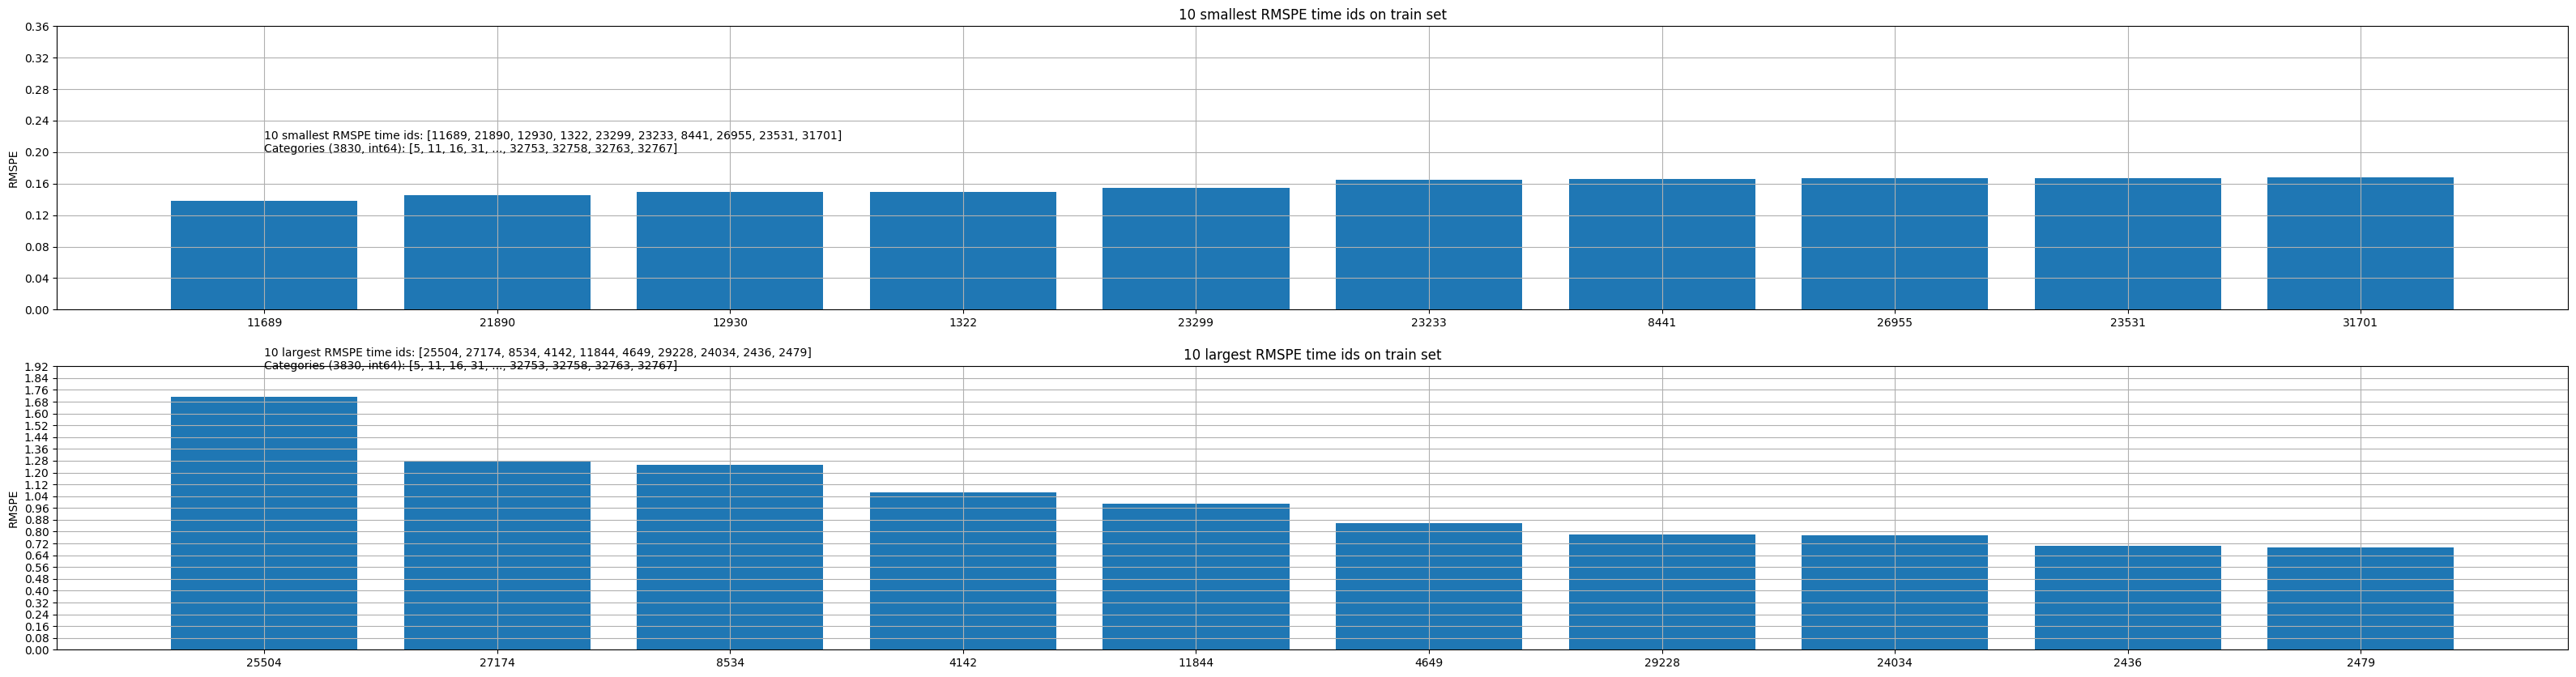

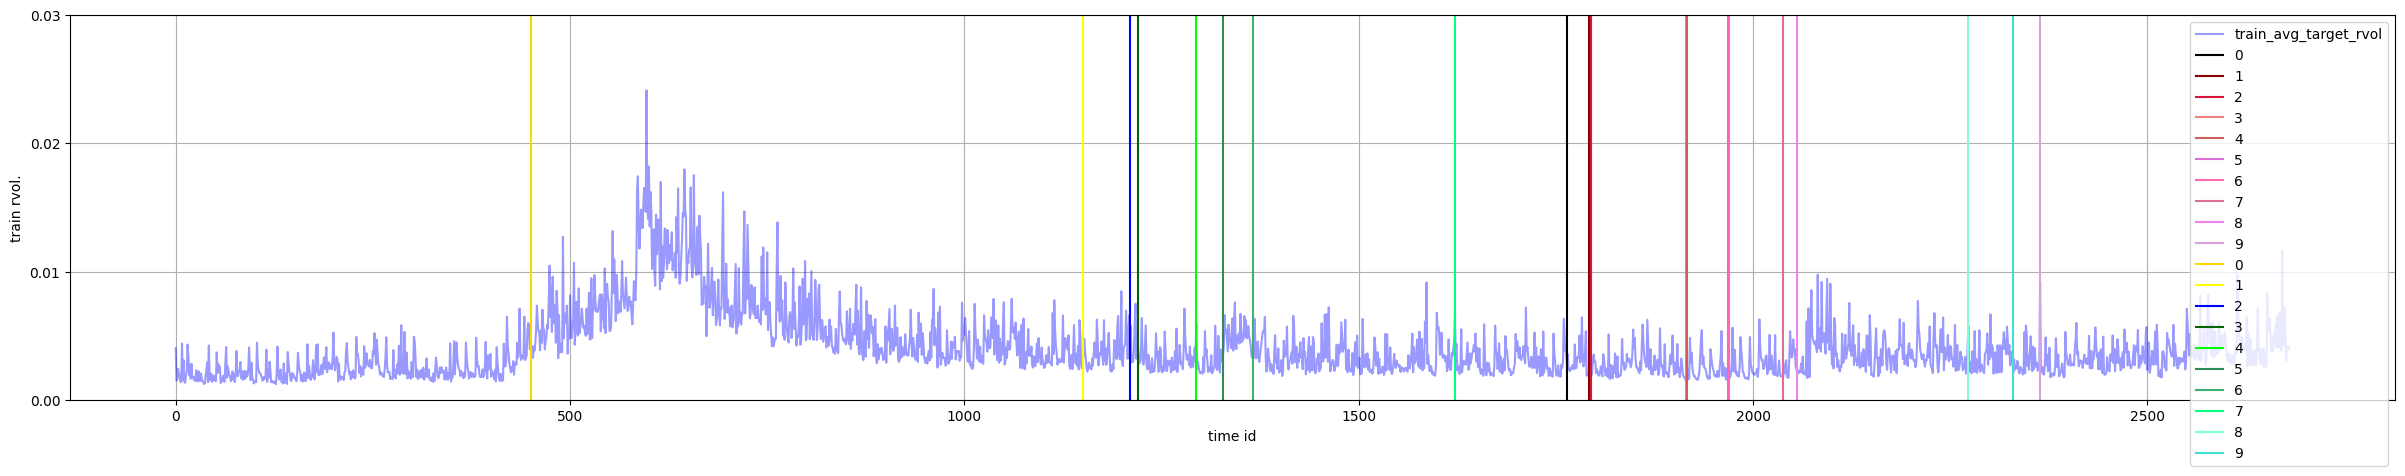


############################## OVERALL TIME ANALYSIS END #################################

###################################### Feature importance & SHAPLEY START #########################################

###################################### Feature importance & SHAPLEY END #########################################

####################################### TESTING SET predictions #################################################
##################################################################################################


In [88]:
"""
TESTER CODE

"""

hand_picked_df = df2 #df2[hand_picked_cols]

t_v_t = train_validate_n_test(hand_picked_df)

os.chdir('/content/drive/MyDrive/optiver_real_vol/temp_results')
final_reg = pickle.load(open("final_reg.pkl", 'rb'))
test_pred = pickle.load(open("test_pred.pkl", 'rb'))
y_test = pickle.load(open("y_test.pkl", 'rb'))
train_pred =pickle.load(open("train_pred.pkl", 'rb'))
y_train = pickle.load(open("y_train.pkl", 'rb'))
X_train = pickle.load(open("X_train.pkl", 'rb'))
v1tr = pickle.load(open("v1tr.pkl", 'rb'))
w_train = pickle.load(open("w_train.pkl", 'rb'))

t_v_t.evaluate_predictions(final_reg,test_pred, y_test,train_pred,y_train, X_train,v1tr,w_train)

In [ ]:
num_trees = 300

def objective(trial):

    #os.chdir("c:\Work\WORK_PACKAGE\Demand_forecasting\BLUESG_Demand_data\Data-preprocessing_data_generation")
    hand_picked_df = df2 #df2[hand_picked_cols]
    t_v_t = train_validate_n_test(hand_picked_df)

    ######  SET Hyperparameter's range for tuning ######
    early_stopping_rounds = 25
    num_round= num_trees
    seed1=11
    missing_value = -np.inf   # Replace with a suitable value

    # Hyperparameters and algorithm parameters are described here
    params = {'disable_default_eval_metric': 1,
              "max_depth": trial.suggest_int('max_depth', 1, 5),
            "eta": trial.suggest_float(name='eta', low=0.01, high=1,log=True),
            "subsample" : round(trial.suggest_float(name='subsample', low=0.5, high=1.0,step=0.1),1),
            "colsample_bytree": round(trial.suggest_float(name='colsample_bytree', low=0.0, high=0.8,step=0.1),1),
            'gamma': trial.suggest_int('gamma', 1, 5),
            'reg_alpha': trial.suggest_int('reg_alpha', 2, 8),
            'reg_lambda': trial.suggest_int('reg_lambda', 2, 5),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 8),
            "tree_method": 'hist',
            "device": "cuda",
            "seed":seed1,
            #'missing': missing_value
            }


    ######  SET Hyperparameter's range for tuning ######

    val_avg_error,best_iteration = t_v_t.xgb_train_validate(params,num_round,early_stopping_rounds,trial)
    trial.set_user_attr("best_iteration", best_iteration)

    del t_v_t
    gc.collect()
    return val_avg_error



In [ ]:


#if __name__ == "__main__":

#optuna.logging.set_verbosity(optuna.logging.WARNING)

study = optuna.create_study(direction="minimize")
study.optimize(objective, timeout=12000, n_trials=25) # 50

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("Trial no.: ",trial.number)
print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

#print("Best hyperparameters:", study.best_params)

fig = optuna.visualization.plot_parallel_coordinate(study)
fig.show()

fig = optuna.visualization.plot_optimization_history(study)
fig.show()

fig = optuna.visualization.plot_slice(study)
fig.show()

fig = optuna.visualization.plot_param_importances(study)
fig.show()



In [ ]:
import plotly.express as px
import pandas as pd

# Define the data including the additional point
data = [
    {'max_depth': 4, 'eta': 0.9196861007028913, 'subsample': 0.9000000000000001, 'colsample_bytree': 0.8, 'gamma': 1, 'reg_alpha': 6, 'reg_lambda': 3, 'min_child_weight': 5},
    {'max_depth': 4, 'eta': 0.100876604356136, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 2, 'reg_alpha': 4, 'reg_lambda': 3, 'min_child_weight': 7},
    {'max_depth': 5, 'eta': 0.16617732858157094, 'subsample': 1.0, 'colsample_bytree': 0.7000000000000001, 'gamma': 1, 'reg_alpha': 2, 'reg_lambda': 2, 'min_child_weight': 3},
    {'max_depth': 5, 'eta': 0.2959486177348714, 'subsample': 0.9000000000000001, 'colsample_bytree': 0.4, 'gamma': 2, 'reg_alpha': 8, 'reg_lambda': 5, 'min_child_weight': 7},
    {'max_depth': 5, 'eta': 0.015182079916871247, 'subsample': 0.8, 'colsample_bytree': 0.5, 'gamma': 2, 'reg_alpha': 8, 'reg_lambda': 3, 'min_child_weight': 1},
    {'max_depth': 3, 'eta': 0.6311080130677539, 'subsample': 0.7, 'colsample_bytree': 0.7000000000000001, 'gamma': 3, 'reg_alpha': 6, 'reg_lambda': 4, 'min_child_weight': 2}
]

# Convert data to DataFrame
df = pd.DataFrame(data)

# Create parallel coordinates plot
fig = px.parallel_coordinates(df, color_continuous_scale=px.colors.diverging.Tealrose,
                               color_continuous_midpoint=2)
fig.show()


In [ ]:
hand_picked_df = df2 #df2[hand_picked_cols]

num_rounds = 127 #study.trials[trial.number].user_attrs['best_iteration']
print('final best iteration: ',num_rounds )
seed1 = 11
missing_value = -np.inf  # Replace with a suitable value


# best_params = { 'disable_default_eval_metric': 1,
#               "max_depth": study.best_params["max_depth"],
#             "eta": study.best_params["eta"],
#             "subsample" : study.best_params["subsample"],
#             "colsample_bytree": study.best_params["colsample_bytree"],
#             'gamma': study.best_params["gamma"],
#             'reg_alpha': study.best_params["reg_alpha"],
#             'reg_lambda': study.best_params["reg_lambda"],
#             'min_child_weight': study.best_params["min_child_weight"],
#             "tree_method": 'hist',
#             "device": "cuda",
#             "seed":seed1,
#             #'missing': missing_value
#                }

best_params = { 'disable_default_eval_metric': 1,
              "max_depth": 3,
            "eta": 0.02425381742074463,
            "subsample" : 0.2,
            "colsample_bytree":  0.4,
            'gamma':3,
            'reg_alpha': 5,
            'reg_lambda': 0,
            'min_child_weight': 5,
            "tree_method": 'hist',
            "device": "cuda",
            "seed":seed1,
            #'missing': missing_value
               }



t_v_t = train_validate_n_test(hand_picked_df)
final_reg,test_pred, y_test,train_pred,y_train = t_v_t.make_predictions(best_params,num_rounds)


os.chdir('/content/drive/MyDrive/optiver_real_vol/temp_results')
final_reg = pickle.load(open("final_reg.pkl", 'rb'))
test_pred = pickle.load(open("test_pred.pkl", 'rb'))
y_test = pickle.load(open("y_test.pkl", 'rb'))
train_pred =pickle.load(open("train_pred.pkl", 'rb'))
y_train = pickle.load(open("y_train.pkl", 'rb'))
X_train = pickle.load(open("X_train.pkl", 'rb'))
v1tr = pickle.load(open("v1tr.pkl", 'rb'))
w_train = pickle.load(open("w_train.pkl", 'rb'))

t_v_t.evaluate_predictions(final_reg,test_pred, y_test,train_pred,y_train, X_train,v1tr,w_train)

# ## save the best model with timestamp for future use.
# timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
# filename = f'xgb_gpu_{timestamp}.pkl'
# os.chdir('/content/drive/MyDrive/optiver_real_vol/Xgboost_gpu_models/xgb_gpu_model_registry')
# with open(filename, 'wb') as file:
#     pickle.dump(final_reg, file)
# print(f'Model saved to: {filename}')
# os.chdir('/content/drive/MyDrive/optiver_real_vol/Datasets/liquidity_features')


# del study, trial,t_v_t,final_reg,test_pred, y_test,train_pred,y_train
# gc.collect()